In [4]:
# Importación de librerías 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples,calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
# Seteo para que no se muestre notación científica
np.set_printoptions(suppress=True)
# Saco los warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Levanto el dataset
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/train.csv'
df = pd.read_csv(url, sep = ',')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Selección de variables
Vamos a probar la metodología intentando detectar clusters que surjan de relacionar las variables GarageArea y GrLivArea.

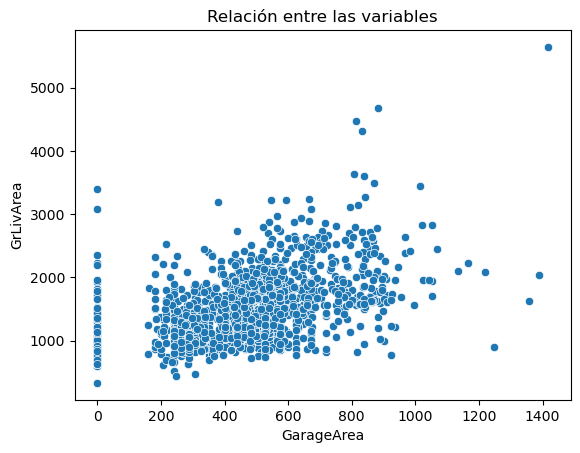

In [6]:
# Relación entre las variables
plt.figure()
sns.scatterplot(data = df,
                x = 'GarageArea',
                y = 'GrLivArea') 
plt.title('Relación entre las variables')
plt.show()

In [7]:
# Separamos en train y test
from sklearn.model_selection import train_test_split

# Variables a procesar
features = ['GrLivArea','GarageArea']

df_limpia = df.dropna(subset= features)
df_train,df_test = train_test_split(df_limpia,
                                    test_size = 0.3, #Porcentaje de muestra test 
                                    random_state = 43) #Semilla
df_train = df_train.reset_index()
df_test = df_test.reset_index()


# Escalando las variables
from sklearn.preprocessing import StandardScaler
X_train = df_train[features].values
X_test = df_test[features].values

# Defino escalador
sc = StandardScaler()
# Genero parámetros con train
X_train = sc.fit_transform(X_train)
# Le aplico el escalador a test
X_test = sc.transform(X_test)

# Genero df
df_train_scaled = pd.DataFrame(data = X_train)
prefijo = "Scaled_"
df_train_scaled.columns = features
df_train_scaled.add_prefix(prefijo)
df_train_scaled = df_train_scaled.add_prefix(prefijo)
df_test_scaled = pd.DataFrame(data = X_test)
prefijo = "Scaled_"
df_test_scaled.columns = features
df_test_scaled = df_test_scaled.add_prefix(prefijo)

df_train_scaled.head()

,Scaled_GrLivArea,Scaled_GarageArea
0,-1.261573,-0.795348
1,0.291001,-2.218041
2,-0.762808,-0.131425
3,-0.617254,-0.809575
4,-0.698765,-1.079887


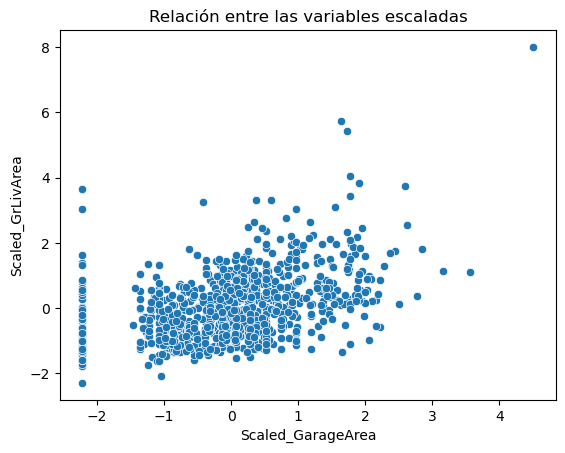

In [8]:
# Relación entre las variables
plt.figure()
sns.scatterplot(data = df_train_scaled,
                x = 'Scaled_GarageArea',
                y = 'Scaled_GrLivArea') 
plt.title('Relación entre las variables escaladas')
plt.show()

# Detección de Outliers 
Dado que la generación de clusters y las métricas asociadas son muy vulnerables a valores atípicos, les daremos tratamiento previo a identificar los clusters óptimos de esta relación. 

In [9]:
from sklearn.ensemble import IsolationForest

# Genero las matrices sin NAs para correr el algoritmo
X_train = df_train_scaled.values
X_test = df_test_scaled.values

# Identificar outliers en el dataset de train
iso = IsolationForest(contamination = 0.005) # contamination = proporcion de outliers esperada
yhat = iso.fit_predict(X_train)

# Marco Outlier en train
df_train_scaled['EsOutlier'] = yhat == (-1)

# En test: 
yhat_test = iso.predict(X_test)
df_test_scaled['EsOutlier'] = yhat_test == (-1)

df_train_scaled.head()

,Scaled_GrLivArea,Scaled_GarageArea,EsOutlier
0,-1.261573,-0.795348,False
1,0.291001,-2.218041,False
2,-0.762808,-0.131425,False
3,-0.617254,-0.809575,False
4,-0.698765,-1.079887,False


Text(0.5, 1.0, 'Identificación Outliers')

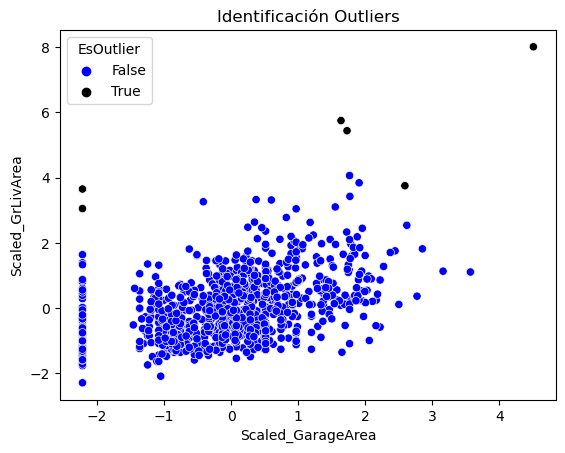

In [10]:
# Visualizo
plt.figure()
sns.scatterplot(data = df_train_scaled,
                x = 'Scaled_GarageArea',
                y = 'Scaled_GrLivArea',
                hue = 'EsOutlier',               
                palette={0: 'blue', 1: 'black'})
plt.title('Identificación Outliers')

# Estrategia para armar Clusters 
Únicamente a los efectos de generar los clusters, dejaremos fuera del análisis a los outliers detectados en el paso anterior. 

Text(0.5, 1.0, 'Relación de variables SIN Outliers')

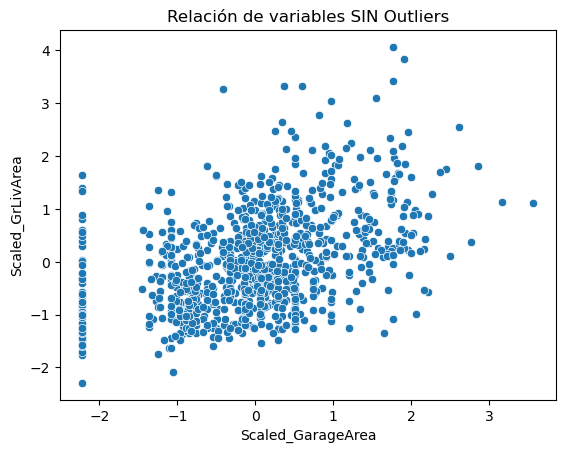

In [11]:
# Filtro
df_train_scaled = df_train_scaled.loc[df_train_scaled['EsOutlier'] == 0,]
df_test_scaled = df_test_scaled.loc[df_test_scaled['EsOutlier'] == 0,]

df_train_scaled = df_train_scaled.drop(columns=['EsOutlier'])
df_test_scaled = df_test_scaled.drop(columns=['EsOutlier'])

# Visualizo
plt.figure()
sns.scatterplot(data = df_train_scaled,
                x = 'Scaled_GarageArea',
                y = 'Scaled_GrLivArea')
plt.title('Relación de variables SIN Outliers')

# Caso particular 
## K-Means con K = 2
A los efectos de interpretar las métricas, generaremos una clasificación de 2 clusters usando el algoritmo de K-Means. 

In [12]:
# K Means
X_train = df_train_scaled.values
X_test = df_test_scaled.values

kmeans = KMeans(n_clusters = 2, 
                init = 'k-means++', 
                random_state = 42,
                max_iter = 100,
                tol = 0.05,
                n_init = 10) 

y_kmeans_train = kmeans.fit_predict(X_train)
y_kmeans_test = kmeans.predict(X_test)

df_train_scaled['Cluster_KMeans'] = y_kmeans_train
df_test_scaled['Cluster_KMeans'] = y_kmeans_test
df_train_scaled.head()

,Scaled_GrLivArea,Scaled_GarageArea,Cluster_KMeans
0,-1.261573,-0.795348,1
1,0.291001,-2.218041,1
2,-0.762808,-0.131425,1
3,-0.617254,-0.809575,1
4,-0.698765,-1.079887,1


Text(0.5, 1.0, 'K-Means (k = 2) - Train')

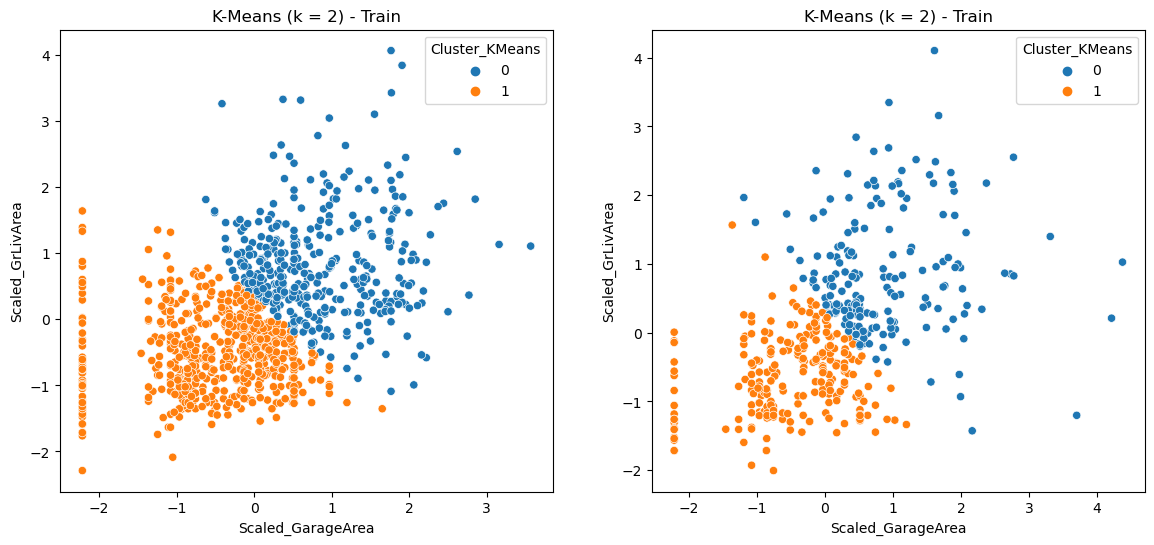

In [13]:
# Visualizo
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

df_train_scaled['Cluster_KMeans'] = df_train_scaled['Cluster_KMeans'].astype('category')
sns.scatterplot(data = df_train_scaled,
                x = 'Scaled_GarageArea',
                y = 'Scaled_GrLivArea',
                hue = 'Cluster_KMeans',
                ax = axs[0])
axs[0].set_title('K-Means (k = 2) - Train')


df_test_scaled['Cluster_KMeans'] = df_test_scaled['Cluster_KMeans'].astype('category')
sns.scatterplot(data = df_test_scaled,
                x = 'Scaled_GarageArea',
                y = 'Scaled_GrLivArea',
                hue = 'Cluster_KMeans',
                ax = axs[1])
axs[1].set_title('K-Means (k = 2) - Train')

## Intentando entender la composición de los clusters
Más allá de las métricas para saber qué tan buenos fueron los agrupamientos, podemos intentar entender qué contiene cada cluster estudiando distribuciones de las variables por cluster, y ciertas medidas de agregación interesantes como promedios o medianas. 

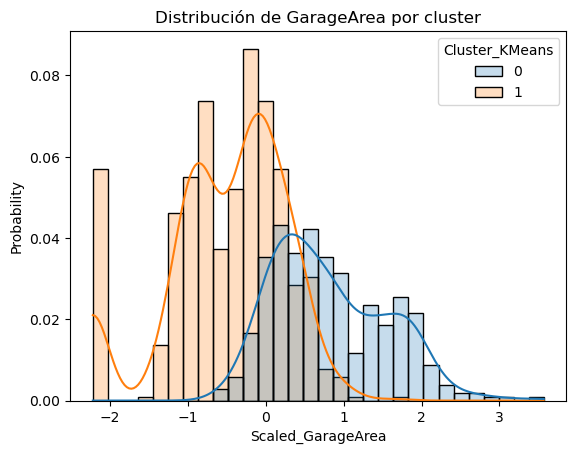

In [14]:
# Histograma
plt.figure()
sns.histplot(data = df_train_scaled,
             x = 'Scaled_GarageArea',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
            hue = 'Cluster_KMeans')
plt.title('Distribución de GarageArea por cluster')
plt.show()

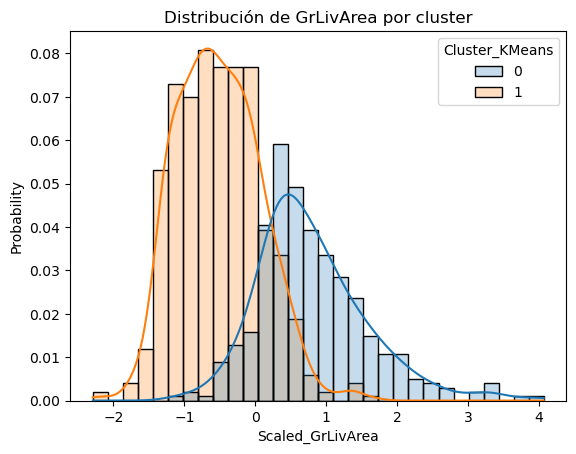

In [15]:
# Histograma
plt.figure()
sns.histplot(data = df_train_scaled,
             x = 'Scaled_GrLivArea',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
            hue = 'Cluster_KMeans')
plt.title('Distribución de GrLivArea por cluster')
plt.show()

In [16]:
# Medidas de agrupación 
resultados = df_train_scaled.groupby('Cluster_KMeans').agg(
    Cant = ('Scaled_GrLivArea', 'count'),
    Prom_GrLivArea = ('Scaled_GrLivArea', 'mean'),
    Med_GrLivArea = ('Scaled_GrLivArea', 'median'),
    Prom_GarageArea = ('Scaled_GarageArea', 'mean'),
    Med_GarageArea = ('Scaled_GarageArea', 'median')
).reset_index()
resultados.round(2)

,Cluster_KMeans,Cant,Prom_GrLivArea,Med_GrLivArea,Prom_GarageArea,Med_GarageArea
0,0,377,0.80,0.64,0.82,0.68
1,1,639,-0.52,-0.56,-0.49,-0.34


# Métricas 

In [17]:
# Silhouette
S_train = silhouette_score(X_train,y_kmeans_train)
S_test = silhouette_score(X_test,y_kmeans_test)

# Davies Bouldin
DB_train = davies_bouldin_score(X_train,y_kmeans_train)
DB_test = davies_bouldin_score(X_test,y_kmeans_test)

# Inercia 
inertia_train = kmeans.inertia_
inertia_test = sum(((X_test[i] - kmeans.cluster_centers_[y_kmeans_test[i]]) ** 2).sum() for i in range(len(X_test)))

# Calinski-Harabasz
CH_train = calinski_harabasz_score(X_train,y_kmeans_train)
CH_test = calinski_harabasz_score(X_test,y_kmeans_test)

In [18]:
print('Métricas de Cluster')
print('')
print('Silhouette')
print('Train: ',round(S_train,3))
print('Test: ',round(S_test,3))
print('')
print('Davies Bouldin')
print('Train: ',round(DB_train,3))
print('Test: ',round(DB_test,3))
print('')
print('Inercia')
print('Train: ',round(inertia_train,3))
print('Test: ',round(inertia_test,3))
print('')
print('Calinski-Harabasz')
print('Train: ',round(CH_train,3))
print('Test: ',round(CH_test,3))

Métricas de Cluster

Silhouette
Train:  0.396
Test:  0.399

Davies Bouldin
Train:  0.962
Test:  0.945

Inercia
Train:  1017.976
Test:  503.853

Calinski-Harabasz
Train:  816.11
Test:  374.794


# Métricas como herramientas para elegir el k óptimo
Ya sabemos que necesitamos: 
- **Silhouette:** Lo más cercana a 1 posible
- **Davies-Bouldin:** Lo más cercano a 0 posible
- **Inercia:** Lo más baja posible
- **Calinski-Harabasz:** Lo más alto posible

<br><br/>
**Entonces:** Vamos a calcular clusters recorriendo k de 2 a 10, calcular estas métricas, y elegir el K que más cantidad de premisas cumpla. 

In [19]:
# Diccionarios vacios para ser almacenados los resultados
sse,db,slc,cal = {}, {}, {}, {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k,
                    init = 'k-means++', 
                    random_state = 42,
                    max_iter = 100,
                    tol = 0.05,
                    n_init = 10).fit(X_train)    
    clusters = kmeans.labels_ # Extraccion de labels
    sse[k] = kmeans.inertia_ # Inercia: Suma de las distancias de las muestras a su centroide mas cercano
    db[k] = davies_bouldin_score(X_train,clusters) # Calculo del indice de Davies Bouldin
    slc[k] = silhouette_score(X_train,clusters) # Calculo del indice de Silhouette
    cal[k] = calinski_harabasz_score(X_train,clusters) # Calculo del indice de Calinski-Harabasz

Text(0.5, 1.0, 'Calinski-Harabasz')

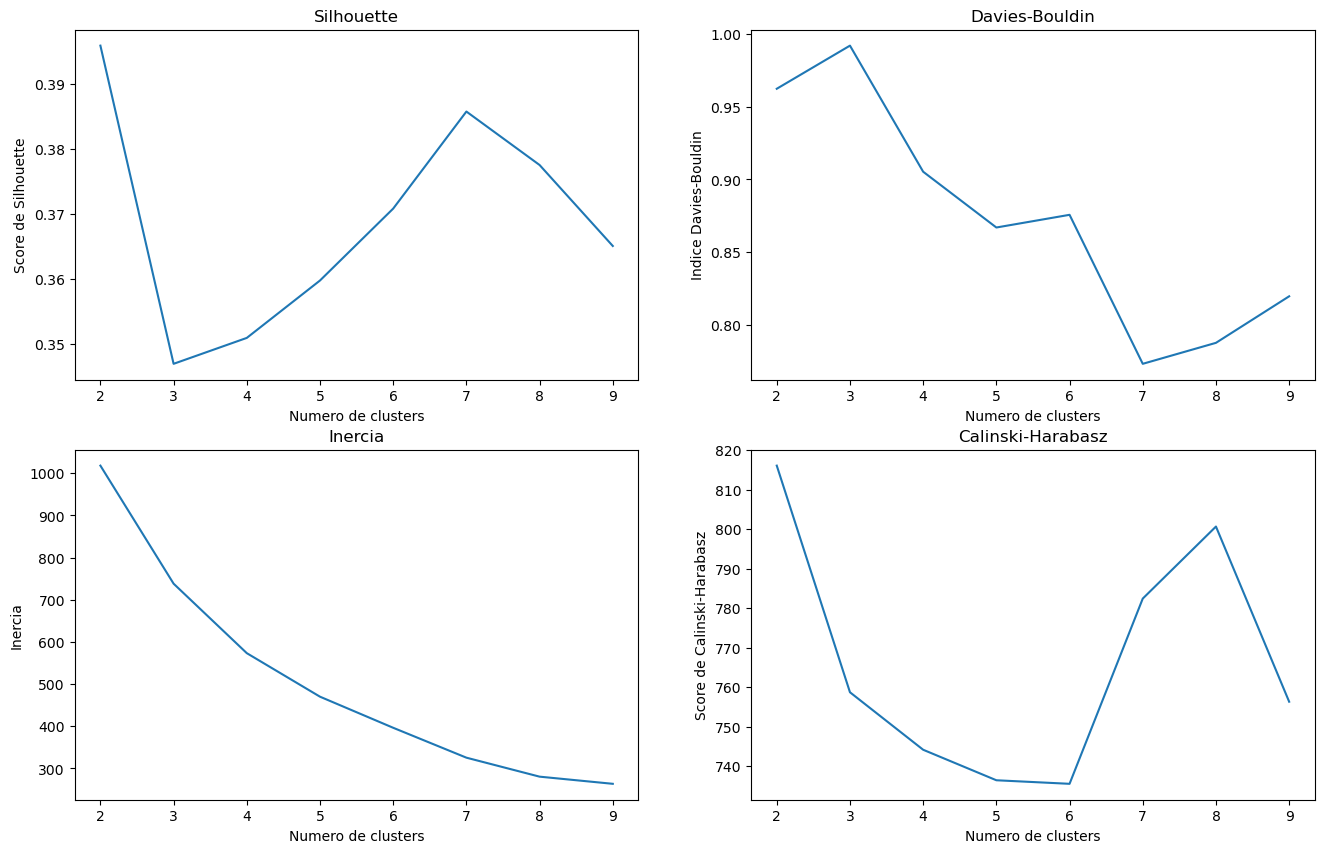

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[0,0].plot(list(slc.keys()), list(slc.values()))
axs[0,0].set_xlabel("Numero de clusters")
axs[0,0].set_ylabel("Score de Silhouette")
axs[0,0].set_title("Silhouette")

axs[0,1].plot(list(db.keys()), list(db.values()))
axs[0,1].set_xlabel("Numero de clusters")
axs[0,1].set_ylabel("Indice Davies-Bouldin")
axs[0,1].set_title("Davies-Bouldin")

axs[1,0].plot(list(sse.keys()), list(sse.values()))
axs[1,0].set_xlabel("Numero de clusters")
axs[1,0].set_ylabel("Inercia")
axs[1,0].set_title("Inercia")

axs[1,1].plot(list(cal.keys()), list(cal.values()))
axs[1,1].set_xlabel("Numero de clusters")
axs[1,1].set_ylabel("Score de Calinski-Harabasz")
axs[1,1].set_title("Calinski-Harabasz")

## Conclusiones: 
- **Según Silhouette:** Mejor k = 2, pero en k = 7 pega otro pico
- **Según Davies-Bouldin:** Mejor k = 7
- **Según Inercia:** Se estabiliza aprox. en k = 7, pero en k = 2 pega otro pico
- **Según Calinski-Harabasz:** Mejor k = 2

<br>
Probemos con k = 7

In [ ]:
# K Means
kmeans = KMeans(n_clusters = 7, 
                init = 'k-means++', 
                random_state = 42,
                max_iter = 100,
                tol = 0.05,
                n_init = 10) 

y_kmeans_train = kmeans.fit_predict(X_train)
y_kmeans_test = kmeans.predict(X_test)

df_train_scaled['Cluster_KMeans'] = y_kmeans_train
df_test_scaled['Cluster_KMeans'] = y_kmeans_test
df_train_scaled.head()

,Scaled_GrLivArea,Scaled_GarageArea,Cluster_KMeans
0,-1.261573,-0.795348,2
1,0.291001,-2.218041,0
2,-0.762808,-0.131425,3
3,-0.617254,-0.809575,2
4,-0.698765,-1.079887,2


Text(0.5, 1.0, 'K-Means (k = 7) - Train')

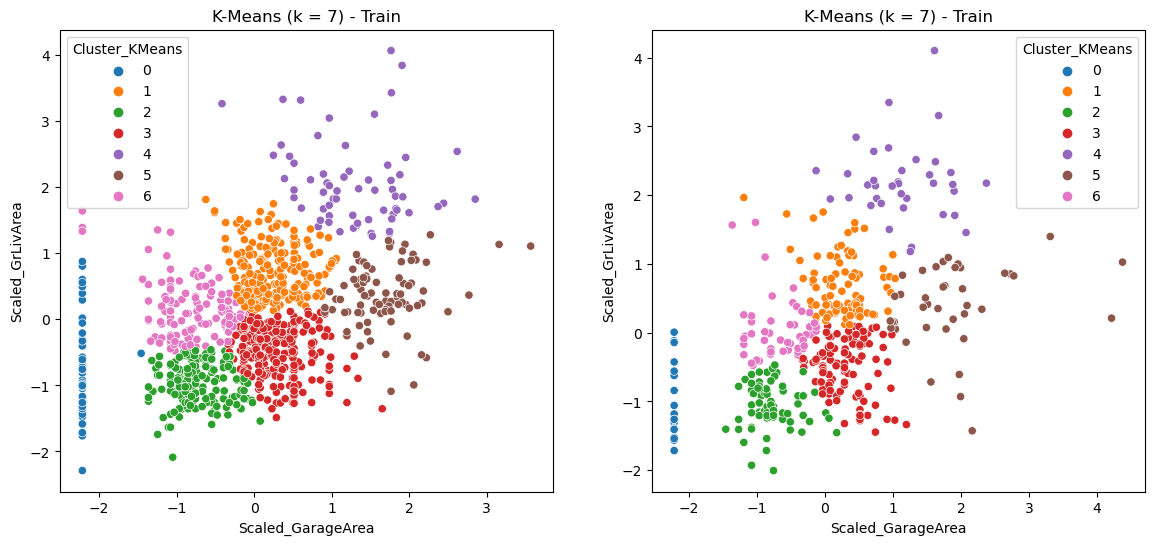

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

df_train_scaled['Cluster_KMeans'] = df_train_scaled['Cluster_KMeans'].astype('category')
sns.scatterplot(data = df_train_scaled,
                x = 'Scaled_GarageArea',
                y = 'Scaled_GrLivArea',
                hue = 'Cluster_KMeans',
                ax = axs[0])
axs[0].set_title('K-Means (k = 7) - Train')


df_test_scaled['Cluster_KMeans'] = df_test_scaled['Cluster_KMeans'].astype('category')
sns.scatterplot(data = df_test_scaled,
                x = 'Scaled_GarageArea',
                y = 'Scaled_GrLivArea',
                hue = 'Cluster_KMeans',
                ax = axs[1])
axs[1].set_title('K-Means (k = 7) - Train')

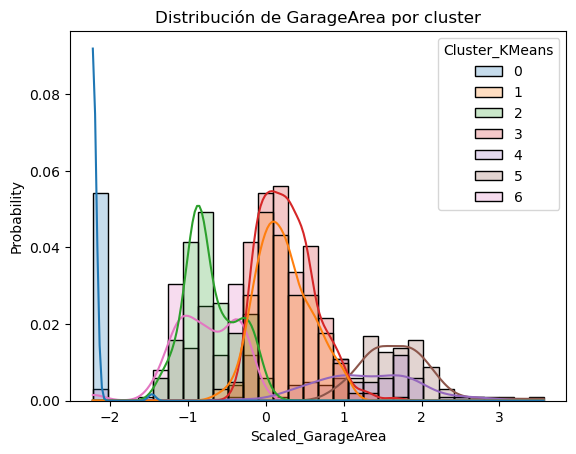

In [ ]:
# Histograma
plt.figure()
sns.histplot(data = df_train_scaled,
             x = 'Scaled_GarageArea',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
            hue = 'Cluster_KMeans')
plt.title('Distribución de GarageArea por cluster')
plt.show()

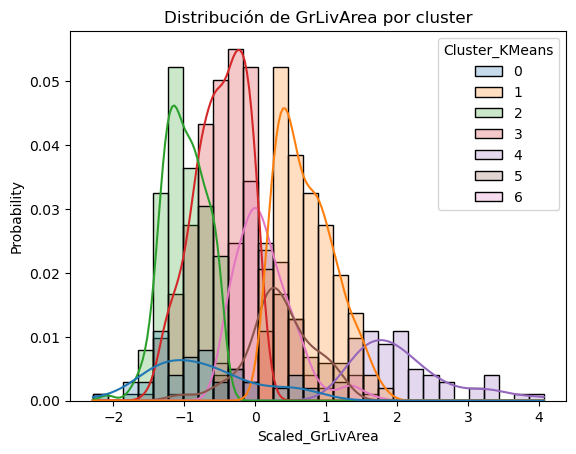

In [ ]:
# Histograma
plt.figure()
sns.histplot(data = df_train_scaled,
             x = 'Scaled_GrLivArea',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
            hue = 'Cluster_KMeans')
plt.title('Distribución de GrLivArea por cluster')
plt.show()

In [ ]:
# Silhouette
S_train = silhouette_score(X_train,y_kmeans_train)
S_test = silhouette_score(X_test,y_kmeans_test)

# Davies Bouldin
DB_train = davies_bouldin_score(X_train,y_kmeans_train)
DB_test = davies_bouldin_score(X_test,y_kmeans_test)

# Inercia 
inertia_train = kmeans.inertia_
inertia_test = sum(((X_test[i] - kmeans.cluster_centers_[y_kmeans_test[i]]) ** 2).sum() for i in range(len(X_test)))

# Calinski-Harabasz
CH_train = calinski_harabasz_score(X_train,y_kmeans_train)
CH_test = calinski_harabasz_score(X_test,y_kmeans_test)

In [ ]:
print('Métricas de Cluster')
print('')
print('Silhouette')
print('Train: ',round(S_train,3))
print('Test: ',round(S_test,3))
print('')
print('Davies Bouldin')
print('Train: ',round(DB_train,3))
print('Test: ',round(DB_test,3))
print('')
print('Inercia')
print('Train: ',round(inertia_train,3))
print('Test: ',round(inertia_test,3))
print('')
print('Calinski-Harabasz')
print('Train: ',round(CH_train,3))
print('Test: ',round(CH_test,3))

Métricas de Cluster

Silhouette
Train:  0.386
Test:  0.373

Davies Bouldin
Train:  0.773
Test:  0.791

Inercia
Train:  325.556
Test:  162.713

Calinski-Harabasz
Train:  782.421
Test:  338.324


# ¿Cómo es la relación de estos 7 clusters con el target? 

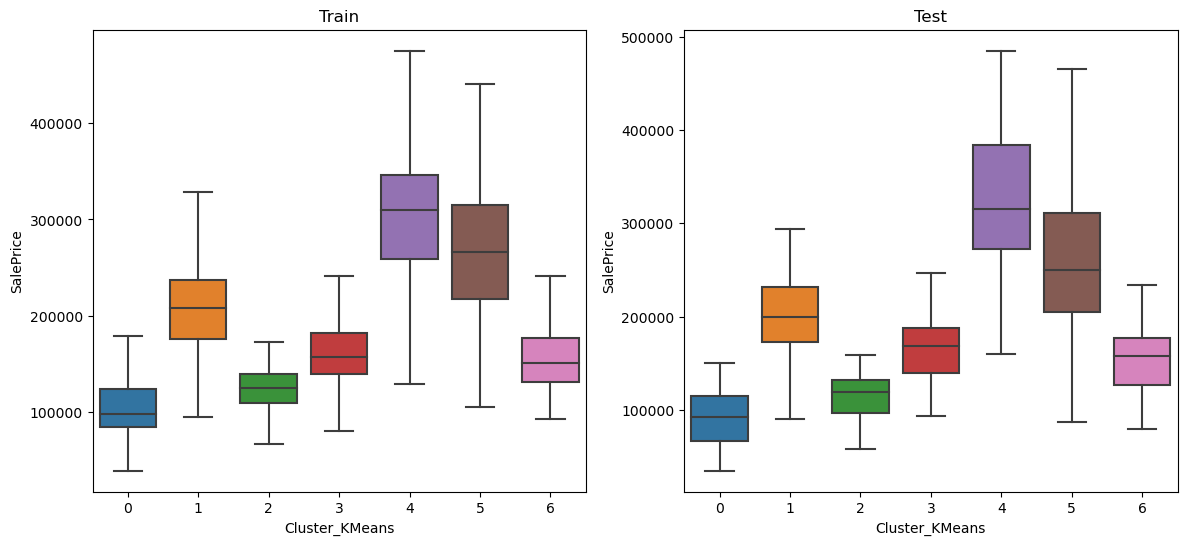

In [ ]:
df_train_scaled['SalePrice'] = df_train['SalePrice']
df_test_scaled['SalePrice'] = df_test['SalePrice']

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data = df_train_scaled,
            x = 'Cluster_KMeans',
            y = 'SalePrice', 
            showfliers = False,
            ax = axs[0])

axs[0].set_title('Train')

sns.boxplot(data = df_test_scaled,
            x = 'Cluster_KMeans',
            y = 'SalePrice', 
            showfliers = False,
            ax = axs[1])


axs[1].set_title('Test')

plt.show()

Text(0.5, 1.0, 'Test')

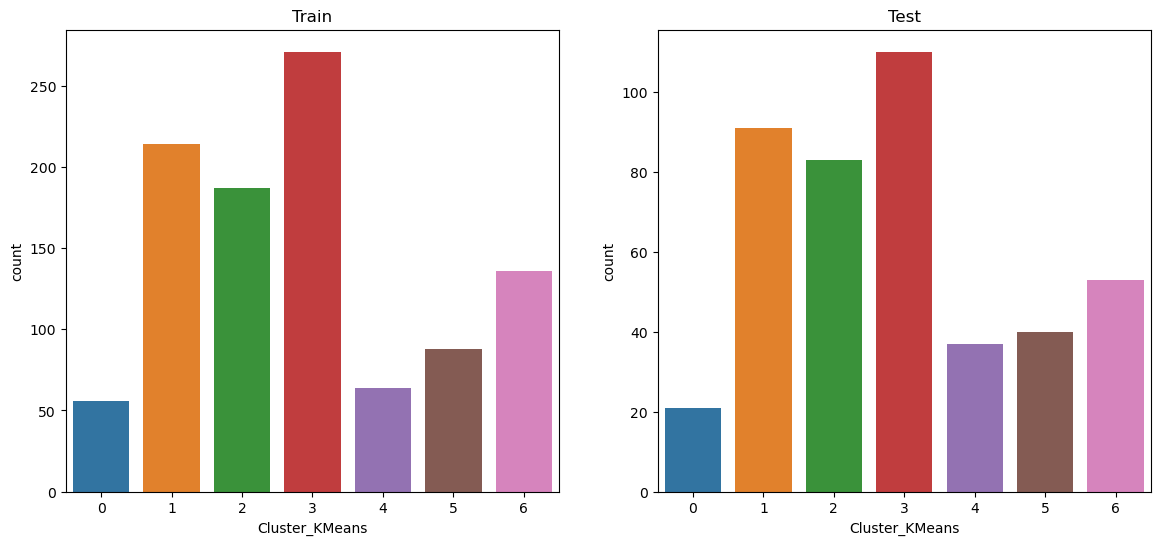

In [ ]:
# Y de volúmen cómo estamos? 
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data = df_train_scaled,
              x = "Cluster_KMeans",
              ax = axs[0])

axs[0].set_title('Train')

sns.countplot(data = df_test_scaled,
              x = "Cluster_KMeans",
              ax = axs[1])

axs[1].set_title('Test')